GREAT: data inspection (python)
================
* **Aim**: Load GREAT spectrum and complete basic baseline subtraction. <br />
* **Data**: Level 3 data. <br />
* **Tools**: astropy <br />
* **Instrument**: GREAT <br />
* **Documentation**: [GREAT observer's handbook](https://www.sofia.usra.edu/instruments/great)
* **Notebook repository**: https://github.com/SOFIAObservatory/Recipes

Goals
-------
* Inspect GREAT data structure
* Plot GREAT spectrum
* Subtract baseline of spectrum

Introduction
--------------

This recipe is a beginner's introduction to plotting GREAT spectra using python. `DS9` and `CLASS` are also excellent options if python is not your favorite coding language. 

Imports 
---------------

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy import units as u
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

Ingredients
---------------

The data come from the [C II Maps in Massive Star Formation Regions](https://www.sofia.usra.edu/data/selected-highlights-data-archive/star-formation/new-c-ii-maps-massive-star-formation-regions) from the FEEDBACK survey. 

#### The slice of the data used in this tutorial can be downloaded directly [here](https://zenodo.org/record/6574619/files/FEEDBACK_RCW120_GREAT_example_subset.fits?download=1), 

You can download the full Level 4 dataset via the [IRSA archive](https://irsa.ipac.caltech.edu/Missions/sofia.html) using the program_ID: 07_0077.


In [2]:
# Load data
hdul = fits.open('example_data/GREAT/FEEDBACK_RCW120_GREAT_example_subset.fits') #Read datacube
data3d = hdul[0].data  #Generate a cleaned 2D image


The shape of the Level 4 GREAT data is 1000 sequential 2D arrays of shape 143 X 143. We use a smaller subset of the data here, but the shape of the data can be inspected using the `hdul[0].data.shape` command.

In [3]:
# view the first 20 lines of the header information
hdul[0].header[0:20]

SIMPLE  =                    T         /                                        
BITPIX  =                  -64                                                  
NAXIS   =                    3         /                                        
NAXIS1  =                  143         /                                        
NAXIS2  =                  144         /                                        
NAXIS3  =                  120                                                  
DATAMIN = -0.9157553100586E+02         /                                        
DATAMAX =  0.2058512420654E+03         /                                        
BUNIT   = 'K (Tmb)     '               /                                        
CTYPE1  = 'RA---GLS    '               /                                        
CRVAL1  =  0.2580152100000E+03         /                                        
CDELT1  = -0.1958333295930E-02         /                                        
CRPIX1  =  0.1061314414072E+

Plot image cube slices
-------------

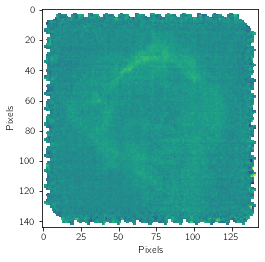

In [4]:
# creates an moment map at index 50
plt.imshow(hdul[0].data[50])
plt.xlabel('Pixels')
plt.ylabel('Pixels'); # trailing semicolon hides text output for Jupyter notebook. 

In [5]:
# plot interactive image (available only in Juypter environment)
from ipywidgets import interactive


def f(image_slice):
    fig = plt.figure(figsize=(4, 4))
    ax1 = fig.add_subplot(1, 1, 1)
    ax1.imshow(hdul[0].data[image_slice])
    plt.show()


interactive_plot = interactive(
    f, image_slice=(0, 99, 1)
)  # change resolution with third value
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=49, description='image_slice', max=99), Output()), _dom_classes=('widget…

Maps and spectra with SpectralCube package
----------------------------

While ploting and analyzing the data can be done with matplotlib, astropy, and the data in it's current form, astropy's `spectral_cube` was designed to easily view and manipulate data cubes in fits format. A tutorial of the package can be found [here](https://spectral-cube.readthedocs.io/en/latest/).

In [6]:
from spectral_cube import SpectralCube

In [7]:
cube = SpectralCube.read(hdul)

In [8]:
print(cube)

SpectralCube with shape=(120, 144, 143):
 n_x:    143  type_x: RA---SFL  unit_x: deg    range:   257.922835 deg:  258.278619 deg
 n_y:    144  type_y: DEC--SFL  unit_y: deg    range:   -38.592069 deg:  -38.312027 deg
 n_s:    120  type_s: VRAD      unit_s: m / s  range:  -109800.001 m / s:  -86000.001 m / s


While we can still plot the data using matplotlib.pyplot with the data in this form `plt.imshow(cube[50,:,:].value);`, we can use SpectralCube's quicklook to explore the data with more useful units. 

Say we want a map of the data at around -93 km/s.

In [9]:
# Calculate the index closest to -93 km/s
ind = cube.closest_spectral_channel(-93*u.km/u.s)
print(ind)

84


INFO: Auto-setting vmin to -1.978e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.785e+01 [aplpy.core]


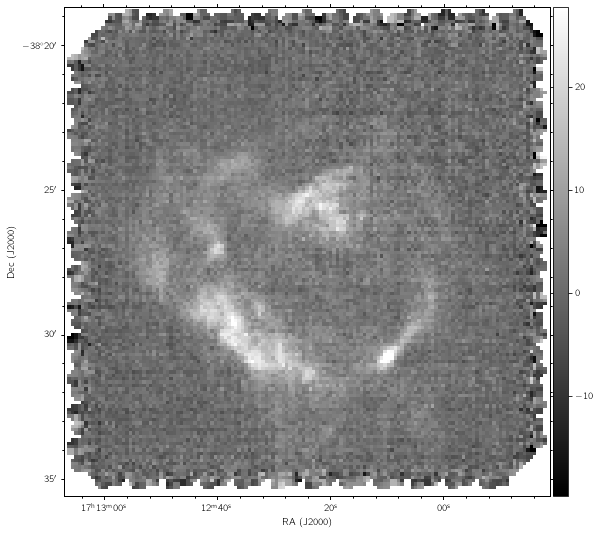

In [10]:
# Plot of the ind slice with WCS on the X and Y axis.

#data are listed in [spectral_index, X_pixel_index, Y_pixel_index]
cube[ind, :, :].quicklook()

Create moment maps
-----------------

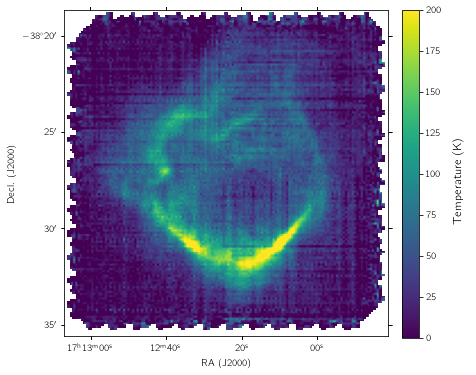

In [11]:
# create a moment map (integrated intensity along the spectral dimension)
moment = cube.with_spectral_unit(u.km / u.s).moment(order=0)

# plot the moment map
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection=moment.wcs)
im = ax.imshow(moment.hdu.data, vmin=0, vmax=200)
plt.xlabel("RA (J2000)")
plt.ylabel("Decl. (J2000)")

# colorbar axis
colorbar_axes = fig.add_axes(
    [0.92, 0.12, 0.04, 0.76]
)  # ([right, width, bottom, height])

plt.colorbar(im, cax=colorbar_axes)

# colorbar text label
plt.annotate(
    "Temperature (K)",
    (
        1.075,
        0.55,
    ),  # realtive position from bottom left (0, 0) to top right (1, 1) of figure.
    xycoords="figure fraction",
    ha="right",
    va="top",
    rotation=90,
    fontsize=12,
)
plt.show()

Extract spectra from datacube
--------------------

For a quick look in a given X,Y pixel range, we can use spectral_cube's quicklook. To change units, we can use the `.with_spectral_unit()` option and specfiy the units using astropy.units (u).

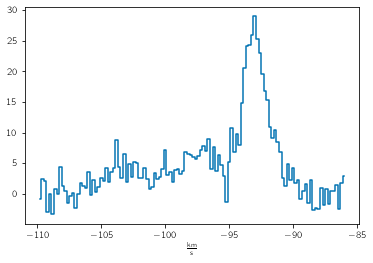

In [12]:
cube.with_spectral_unit(u.km / u.s)[:, 50, 50].quicklook()

Simple continuum subtraction
-------------

In [13]:
med = cube.median(axis=0)  
med_sub_cube = cube - med

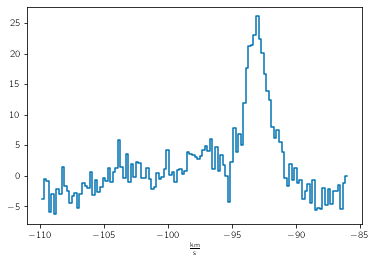

In [14]:
med_sub_cube.with_spectral_unit(u.km / u.s)[:, 50, 50].quicklook()